# Парсим датасет

In [2]:
import pandas as pd

data = {}

path_to_data = r'all_time-series/ts_cut'

import os
import numpy as np
import re

parser_regex = r'(ihb|china|rmet)_(open|close)_strategy-(\d)_(GSR|noGSR).npy'
extractor = re.compile(parser_regex)

items = {atlas_name: {dataset_name: []
                      for dataset_name in ['china', 'ihb', 'rmet']}
         for atlas_name in ['HCPex', 'Brainnetome', 'AAL', 'Schaefer200']}

for root, dirs, files in os.walk(path_to_data):
    for file in files:
        atlas = root.split(os.sep)[1]
        source = root.split(os.sep)[2]
        items[atlas][source].append(np.load(os.path.join(root, file)))

In [4]:
q_pictures = 24
q_times = 120
q_brain_parts = 246

# Здесь об активности мозга на всем временном ряду

### Зеленые и желтые точки - больше активности. Синие и фиолетовые - меньше.

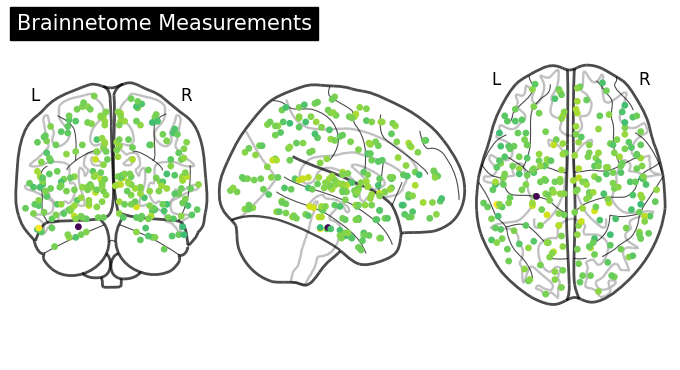

In [10]:
coords = pd.read_csv('bnt.txt')

import numpy as np
from nilearn import plotting
from IPython.display import clear_output

# from first person with open eyes strategy 6 noGSR
measurements = items['Brainnetome']['rmet'][-1][0] 
# connectivity = np.corrcoef(measurements.T)
connectivity = np.zeros((q_brain_parts, q_brain_parts))
for time in range(q_times):
    plotting.plot_connectome(connectivity, coords,
                               node_color=measurements[time],
                               node_size=15,
                               edge_threshold='99.9%', 
                               title="Brainnetome Measurements")
    plotting.show()
    clear_output(wait=True)

# Тут делаем матрицу корреляций и делим на классы при помощи fcluster

In [6]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# не всегда np.corrcoef корректно возвращает
corr = np.corrcoef(measurements.T)
corr = (corr + corr.T) / 2                         # made symmetric
np.fill_diagonal(corr, 1)                        # put 1 on the diagonal

dissimilarity = 1 - np.abs(corr)
hierarchy = linkage(squareform(dissimilarity), method='average')
labels = fcluster(hierarchy, 0.5, criterion='distance')

# Делаем 3D визуализацию коррелирующих между собой частей мозга у одного конкретного человека

In [9]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import trimesh

def generate_distinct_colors(num_colors):
    cmap = plt.get_cmap('tab20', num_colors)
    return [cmap(i) for i in range(num_colors)]

colors = generate_distinct_colors(89)

# Создание фигуры
fig = go.Figure()

# Проход по каждому кластеру
for cluster_id in np.unique(labels):
    # Получение точек, принадлежащих текущему кластеру
    cluster_points = coords[labels == cluster_id]

    # Добавление точек кластера на график
    fig.add_trace(go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(size=5, color=f'rgba{colors[cluster_id]}'),
        name=f'Кластер {cluster_id + 1}'
    ))

    # Проверка, достаточно ли точек для построения выпуклой оболочки
    if len(cluster_points) >= 4:  # ConvexHull требует минимум 4 точки
        hull = ConvexHull(cluster_points)
        edges = set()
        # Проход по граням выпуклой оболочки
        for simplex in hull.simplices:
            for i in range(len(simplex)):
                edge = tuple(sorted((simplex[i], simplex[(i + 1) % len(simplex)])))
                edges.add(edge)
        # Добавление линий, соответствующих границам выпуклой оболочки
        for edge in edges:
            fig.add_trace(go.Scatter3d(
                x=cluster_points[edge, 0],
                y=cluster_points[edge, 1],
                z=cluster_points[edge, 2],
                mode='lines',
                line=dict(color=f'rgba{colors[cluster_id]}', width=2),
                showlegend=False
            ))
            
        # Проверка, достаточно ли точек для построения выпуклой оболочки
        if len(cluster_points) >= 4:  # ConvexHull требует минимум 4 точки
            hull = ConvexHull(cluster_points)
            # Добавление поверхности выпуклой оболочки
            fig.add_trace(go.Mesh3d(
                x=cluster_points[hull.vertices, 0],
                y=cluster_points[hull.vertices, 1],
                z=cluster_points[hull.vertices, 2],
                color='rgb({}, {}, {})'.format(*[int(c*255) for c in colors[cluster_id]]),
                opacity=0.5,
                name=f'Оболочка кл-а {cluster_id + 1}',
                alphahull=0,
            ))

# Настройка осей и отображение графика
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Визуализация кластеров с границами выпуклой оболочки'
)

fig.write_html('graph3.html', auto_open=True)